In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf  # For tf.data
import matplotlib.pyplot as plt
import keras
from tensorflow import keras
from keras import layers
from keras.applications import EfficientNetB0
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
import seaborn as sns
import pickle
import pandas as pd
import json

2024-08-29 10:53:46.107044: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-29 10:53:46.107174: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-29 10:53:46.243669: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from tensorflow.keras.models import load_model

# Load the model saved in Keras HDF5 format
model = load_model("/kaggle/input/cifar9_95acc/tensorflow2/cifar9_95acc/1/mnv2_cifar9_160_fbn_4.keras")

NUM_CLASSES = 10
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# create n- and m-datasets
def create_datasets(x, y, n_classes):

    x_n = []
    y_n = []
    x_m = []
    y_m = []
    for x_, y_ in zip (x, y):
        if y_ in n_classes:
            x_n.append(x_)
            y_n.append(y_)
        else:
            x_m.append(x_)
            y_m.append(y_)
    return np.array(x_n), np.array(y_n), np.array(x_m), np.array(y_m)
    
n_classes = [0, 1, 2, 3, 4, 5, 6, 7,8]
x_train_n, y_train_n, x_train_m, y_train_m = create_datasets(x_train, y_train, n_classes)
x_test_n, y_test_n, x_test_m, y_test_m = create_datasets(x_test, y_test, n_classes)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

y_train_n = tf.keras.utils.to_categorical(y_train_n, num_classes=10)
y_test_n = tf.keras.utils.to_categorical(y_test_n, num_classes=10)

y_train_m = tf.keras.utils.to_categorical(y_train_m, num_classes=10)
y_test_m = tf.keras.utils.to_categorical(y_test_m, num_classes=10)

# preprocessing
IMAGE_SHAPE = (160, 160, 3)

preprocessing = keras.Sequential(
    [
        layers.Rescaling(1./255.0, offset=0),
        layers.Resizing(IMAGE_SHAPE[0], IMAGE_SHAPE[1], interpolation='bilinear')
    ],
    name="preprocessing",
)

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.15),
        layers.RandomContrast(factor=0.1),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)

IMG_SIZE = 160
BATCH_SIZE = 128
BUFFER_SIZE = BATCH_SIZE * 10
AUTO = tf.data.AUTOTUNE

# original
ds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
ds_train = ds_train.shuffle(ds_train.cardinality()).batch(BATCH_SIZE).map(lambda x, y: (data_augmentation(preprocessing(x)), y)).prefetch(AUTO)

ds_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))
ds_test = ds_test.batch(BATCH_SIZE).map(lambda x, y: (preprocessing(x), y)).prefetch(AUTO)

# n-dataset
ds_train_n = tf.data.Dataset.from_tensor_slices((x_train_n, y_train_n))
ds_train_n = ds_train_n.shuffle(ds_train_n.cardinality()).batch(BATCH_SIZE).map(lambda x, y: (data_augmentation(preprocessing(x)), y)).prefetch(AUTO)

ds_test_n = tf.data.Dataset.from_tensor_slices((x_test_n, y_test_n))
ds_test_n = ds_test_n.batch(BATCH_SIZE).map(lambda x, y: (preprocessing(x), y)).prefetch(AUTO)

# m-dataset
ds_train_m = tf.data.Dataset.from_tensor_slices((x_train_m, y_train_m))
ds_train_m = ds_train_m.shuffle(ds_train_m.cardinality()).batch(BATCH_SIZE).map(lambda x, y: (data_augmentation(preprocessing(x)), y)).prefetch(AUTO)

ds_test_m = tf.data.Dataset.from_tensor_slices((x_test_m, y_test_m))
ds_test_m = ds_test_m.batch(BATCH_SIZE).map(lambda x, y: (preprocessing(x), y)).prefetch(AUTO)

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 164 variables whereas the saved optimizer has 476 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [4]:
ds_train_m = ds_train_m.unbatch().batch(1)
ds_train_n = ds_train_n.unbatch().batch(1)

In [5]:
ds_test_n = ds_test_n.unbatch().batch(1)

In [6]:
ds_test_m = ds_test_m.unbatch().batch(1)

## Experiment: Best and Worst images for model 

In [7]:
def calculate_bvsb(probs):
    sorted_probs = np.sort(probs, axis=1)[:, ::-1]
    bvsb = sorted_probs[:, 0] - sorted_probs[:, 1]
    return bvsb

def save_images(images, output_dir, image_format='PNG'):
    os.makedirs(output_dir, exist_ok=True)
    
    for idx, image in enumerate(images):
        image = np.clip(image, 0.0, 1.0)
        image_uint8 = (image.squeeze() * 255.0).astype(np.uint8)
        if image_uint8.shape[0] == 3:
            image_uint8 = np.transpose(image_uint8, (1, 2, 0))
        image_pil = Image.fromarray(image_uint8)
        temp_image_path = os.path.join(output_dir, f'image_{idx}.{image_format.lower()}')
        image_pil.save(temp_image_path, format=image_format)


In [8]:
""" 
import numpy as np
import os
import absl.logging
from PIL import Image
import os
import zipfile
# Initialize logging before any significant operations

# Define the directory to save outputs in Kaggle

n_labels = [0,1,2,3, 4, 5, 6, 7]

opt = keras.optimizers.Adam(learning_rate=0.000001, epsilon=0.002, amsgrad=True, weight_decay=1e-5)
loss = keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])
best_count = 0 
for i in n_labels:
    best_samples = []
    worst_samples = [] 
    bsvb_data = []
    count= 0
    n_labels_copy = n_labels.copy()
    n_labels_copy.remove(i)
    n_labels_ = tf.keras.utils.to_categorical(n_labels_copy, num_classes=10)
    for x, y in ds_train_n:
        if  not any(np.array_equal(y[0].numpy(), n) for n in n_labels_):
            prediction = model.predict(x,verbose=0)
            if(np.argmax(y)==np.argmax(prediction)):
                bvsb = calculate_bvsb(prediction)
                bsvb_data.append((x, y.numpy(), bvsb[0]))
        
    
    sorted_bsvb_data = sorted(bsvb_data, key=lambda x: x[2])
    x_y = [item[0] for item in sorted_bsvb_data]
    worst = x_y[:20]
    best = x_y[-20:]
    arr_1 = []
    for x in worst:
        arr_1.append(x.numpy())
    arr_2 = []
    for x in best:
        arr_2.append(x.numpy())

    output_zip_path = f'/kaggle/working/worst_images_{i}'
    save_images(arr_1, output_zip_path, image_format='PNG')
    output_zip_path = f'/kaggle/working/best_images_{i}'
    save_images(arr_2, output_zip_path, image_format='PNG')
""" 


' \nimport numpy as np\nimport os\nimport absl.logging\nfrom PIL import Image\nimport os\nimport zipfile\n# Initialize logging before any significant operations\n\n# Define the directory to save outputs in Kaggle\n\nn_labels = [0,1,2,3, 4, 5, 6, 7]\n\nopt = keras.optimizers.Adam(learning_rate=0.000001, epsilon=0.002, amsgrad=True, weight_decay=1e-5)\nloss = keras.losses.CategoricalCrossentropy(label_smoothing=0.1)\nmodel.compile(optimizer=opt, loss=loss, metrics=["accuracy"])\nbest_count = 0 \nfor i in n_labels:\n    best_samples = []\n    worst_samples = [] \n    bsvb_data = []\n    count= 0\n    n_labels_copy = n_labels.copy()\n    n_labels_copy.remove(i)\n    n_labels_ = tf.keras.utils.to_categorical(n_labels_copy, num_classes=10)\n    for x, y in ds_train_n:\n        if  not any(np.array_equal(y[0].numpy(), n) for n in n_labels_):\n            prediction = model.predict(x,verbose=0)\n            if(np.argmax(y)==np.argmax(prediction)):\n                bvsb = calculate_bvsb(predict

In [9]:
import numpy as np
import os
import absl.logging
from PIL import Image
import os
import zipfile
arr= []
for x,y in ds_train_m:
    arr.append(x.numpy())
    if len(arr)== 160:
        break
output_zip_path = f'/kaggle/working/ds_train_m_'
save_images(arr, output_zip_path, image_format='PNG')


In [ ]:
import numpy as np
import os
import absl.logging
from PIL import Image
import os
import zipfile
# Initialize logging before any significant operations

# Define the directory to save outputs in Kaggle

n_labels = [0,1,2,3, 4, 5, 6, 7,8]

opt = keras.optimizers.Adam(learning_rate=0.000001, epsilon=0.002, amsgrad=True, weight_decay=1e-5)
loss = keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])
best_count = 0 
for i in n_labels:
    best_samples = []
    worst_samples = [] 
    bsvb_data = []
    count= 0
    n_labels_copy = n_labels.copy()
    n_labels_copy.remove(i)
    n_labels_ = tf.keras.utils.to_categorical(n_labels_copy, num_classes=10)
    for x, y in ds_train_n:
        if  not any(np.array_equal(y[0].numpy(), n) for n in n_labels_):         
            bsvb_data.append(x.numpy())
            if len(bsvb_data)== 10:
                break
        

    
    output_zip_path = f'/kaggle/working/n_random_images_{i}'
    save_images(bsvb_data, output_zip_path, image_format='PNG')


' \nimport numpy as np\nimport os\nimport absl.logging\nfrom PIL import Image\nimport os\nimport zipfile\n# Initialize logging before any significant operations\n\n# Define the directory to save outputs in Kaggle\n\nn_labels = [0,1,2,3, 4, 5, 6, 7,8]\n\nopt = keras.optimizers.Adam(learning_rate=0.000001, epsilon=0.002, amsgrad=True, weight_decay=1e-5)\nloss = keras.losses.CategoricalCrossentropy(label_smoothing=0.1)\nmodel.compile(optimizer=opt, loss=loss, metrics=["accuracy"])\nbest_count = 0 \nfor i in n_labels:\n    best_samples = []\n    worst_samples = [] \n    bsvb_data = []\n    count= 0\n    n_labels_copy = n_labels.copy()\n    n_labels_copy.remove(i)\n    n_labels_ = tf.keras.utils.to_categorical(n_labels_copy, num_classes=10)\n    for x, y in ds_train_n:\n        if  not any(np.array_equal(y[0].numpy(), n) for n in n_labels_):         \n            bsvb_data.append(x.numpy())\n            if len(bsvb_data)== 10:\n                break\n        \n\n    \n    output_zip_path = 

Choose 93 samples from ds_train_m:

In [ ]:
m_samples = []
i =0 
for x, y in ds_train_m:
    m_samples.append(x.numpy())
    if i == 139:
        break
    i+=1 

output_zip_path = '/kaggle/working/m_samples'
save_images(m_samples, output_zip_path, image_format='PNG')


" \nm_samples = []\ni =0 \nfor x, y in ds_train_m:\n    m_samples.append(x.numpy())\n    if i == 139:\n        break\n    i+=1 \n\noutput_zip_path = '/kaggle/working/m_samples'\nsave_images(m_samples, output_zip_path, image_format='PNG')\n"

## Experiment: Find Samples from ds_train_n that keep the accuracy of model stable

In [ ]:
model.evaluate(ds_test_n,verbose=0)

In [ ]:
n_labels = [0,1,2,3, 4, 5, 6, 7,8]
accuracies_n = []
for i in n_labels:
    
    n_labels_copy = n_labels.copy()
    n_labels_copy.remove(i)
    n_labels_ = tf.keras.utils.to_categorical(n_labels_copy, num_classes=10)
    x_t = []
    y_t = []
    for x,y in ds_test_n:
        if  not any(np.array_equal(y[0].numpy(), n) for n in n_labels_):
            x_t.append(x.numpy())
            y_t.append(y.numpy())
    

    ds_class = tf.data.Dataset.from_tensor_slices((x_t,y_t))  
    _,acc = model.evaluate(ds_class,verbose=0)
    accuracies_n.append(acc)
    print("For class {}: evaluation is {}".format(i,acc))


' \nn_labels = [0,1,2,3, 4, 5, 6, 7,8]\naccuracies_n = []\nfor i in n_labels:\n    \n    n_labels_copy = n_labels.copy()\n    n_labels_copy.remove(i)\n    n_labels_ = tf.keras.utils.to_categorical(n_labels_copy, num_classes=10)\n    x_t = []\n    y_t = []\n    for x,y in ds_test_n:\n        if  not any(np.array_equal(y[0].numpy(), n) for n in n_labels_):\n            x_t.append(x.numpy())\n            y_t.append(y.numpy())\n    \n\n    ds_class = tf.data.Dataset.from_tensor_slices((x_t,y_t))  \n    _,acc = model.evaluate(ds_class,verbose=0)\n    accuracies_n.append(acc)\n    print("For class {}: evaluation is {}".format(i,acc))\n  '

**1)Stratified Sampling**

In [ ]:
from sklearn.model_selection import train_test_split

n_labels = [0,1,2,3,4, 5, 6, 7,8]
accuracies_sampled = []
sampled_datasets = []
for i in n_labels:
    
    n_labels_copy = n_labels.copy()
    n_labels_copy.remove(i)
    n_labels_ = tf.keras.utils.to_categorical(n_labels_copy, num_classes=10)
    x_test = []
    y_test = []
    for x,y in ds_test_n:
        if  not any(np.array_equal(y[0].numpy(), n) for n in n_labels_):
            x_test.append(x.numpy())
            y_test.append(i)
   
    x_test = np.array(x_test, dtype=np.float32)
    y_test = np.array(y_test, dtype=np.float32)
    test_size = 0.3  
    random_seed = 42  
    x_sampled, _, y_sampled, _ = train_test_split(
        x_test, y_test, test_size=test_size, stratify=y_test, random_state=random_seed
    )
    ds_test_sampled = tf.data.Dataset.from_tensor_slices((x_sampled, tf.keras.utils.to_categorical(y_sampled, num_classes=10)))
    _, acc_sampled = model.evaluate(ds_test_sampled, verbose=0)
    accuracies_sampled.append(acc_sampled)
    
    sampled_datasets.append(accuracies_sampled)
    
combined_dataset = sampled_datasets[0]
for ds in sampled_datasets[1:]:
    combined_dataset = combined_dataset.concatenate(ds)

_, acc_combined = model.evaluate(combined_dataset, verbose=0)
print(f"Combined dataset evaluation accuracy is {acc_combined}")


'\nfrom sklearn.model_selection import train_test_split\n\nn_labels = [0,1,2,3,4, 5, 6, 7,8]\naccuracies_sampled = []\nsampled_datasets = []\nfor i in n_labels:\n    \n    n_labels_copy = n_labels.copy()\n    n_labels_copy.remove(i)\n    n_labels_ = tf.keras.utils.to_categorical(n_labels_copy, num_classes=10)\n    x_test = []\n    y_test = []\n    for x,y in ds_test_n:\n        if  not any(np.array_equal(y[0].numpy(), n) for n in n_labels_):\n            x_test.append(x.numpy())\n            y_test.append(i)\n   \n    x_test = np.array(x_test, dtype=np.float32)\n    y_test = np.array(y_test, dtype=np.float32)\n    test_size = 0.3  \n    random_seed = 42  \n    x_sampled, _, y_sampled, _ = train_test_split(\n        x_test, y_test, test_size=test_size, stratify=y_test, random_state=random_seed\n    )\n    ds_test_sampled = tf.data.Dataset.from_tensor_slices((x_sampled, tf.keras.utils.to_categorical(y_sampled, num_classes=10)))\n    _, acc_sampled = model.evaluate(ds_test_sampled, verbos

In [15]:
from sklearn.model_selection import train_test_split
n_labels = [0,1,2,3, 4, 5, 6, 7,8]
x_test = []
y_test = []
labels = []
for x,y in ds_test_n:  
    x_test.append(x.numpy())
    y_test.append(np.argmax(y))
  
x_test = np.array(x_test,dtype=np.float32)
y_test = np.array(y_test,dtype=np.float32)
test_size = 270
random_seed = 42  
_,x_sampled,_, y_sampled = train_test_split(
    x_test, y_test,test_size = test_size , stratify=y_test, random_state=random_seed
)

y=  tf.keras.utils.to_categorical(y_sampled, num_classes=10)

ds_test_sampled = tf.data.Dataset.from_tensor_slices((x_sampled, y))
def reshape_y(x, y):
    y = tf.reshape(y, (1, 10))
    return x, y
ds_test_stratified = ds_test_sampled.map(reshape_y)
for i in n_labels:
    arr = []
    count = 0 
    n_labels_copy = n_labels.copy()
    n_labels_copy.remove(i)
    n_labels_ = tf.keras.utils.to_categorical(n_labels_copy, num_classes=10)
    for x,y in ds_test_stratified:
        if  not any(np.array_equal(y[0].numpy(), n) for n in n_labels_):
            count+=1
            arr.append(x.numpy())
    #output_zip_path =f'/kaggle/working/ds_test_strartified_{i}'
   # save_images(arr, output_zip_path, image_format='PNG')
    print("samples of class {} = {}".format(i,count))
            
    
_, acc_sampled = model.evaluate( ds_test_stratified, verbose=0)
acc_sampled



samples of class 0 = 30
samples of class 1 = 30
samples of class 2 = 30
samples of class 3 = 30
samples of class 4 = 30
samples of class 5 = 30
samples of class 6 = 30
samples of class 7 = 30
samples of class 8 = 30


I0000 00:00:1724928879.556951      67 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


0.9629629850387573

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure the plots are displayed inline in Jupyter Notebooks
%matplotlib inline

# Assuming y_test is already a numpy array of class labels
class_counts = np.bincount(y_test.astype(int))  # Count the occurrences of each class
class_labels = np.arange(len(class_counts))     # Generate class labels

# Set up the plot
plt.figure(figsize=(10, 6))

# Create the bar plot
sns.barplot(x=class_labels, y=class_counts, palette='viridis')

# Add titles and labels
plt.title('Distribution of Images per Class')
plt.xlabel('Class Label')
plt.ylabel('Number of Images')

# Display the plot
plt.show()


" \nimport matplotlib.pyplot as plt\nimport seaborn as sns\nimport numpy as np\n\n# Ensure the plots are displayed inline in Jupyter Notebooks\n%matplotlib inline\n\n# Assuming y_test is already a numpy array of class labels\nclass_counts = np.bincount(y_test.astype(int))  # Count the occurrences of each class\nclass_labels = np.arange(len(class_counts))     # Generate class labels\n\n# Set up the plot\nplt.figure(figsize=(10, 6))\n\n# Create the bar plot\nsns.barplot(x=class_labels, y=class_counts, palette='viridis')\n\n# Add titles and labels\nplt.title('Distribution of Images per Class')\nplt.xlabel('Class Label')\nplt.ylabel('Number of Images')\n\n# Display the plot\nplt.show()\n"

In [ ]:
from PIL import Image
import os
import zipfile
ds_list = [(x.numpy(),np.argmax(y)) for x,y in ds_test_sampled]
test_img = [item[0] for item in ds_list]
test_labels = [item[1] for item in ds_list]
output_zip_path = '/kaggle/working/test_X_cifar10'
save_images(test_img, output_zip_path, image_format='PNG')

with open('/kaggle/working/test_Y_cifar10.txt', 'w') as f:
    for item in test_labels:
        f.write(f"{item}\n")


' \nds_list = [(x.numpy(),np.argmax(y)) for x,y in ds_test_sampled]\ntest_img = [item[0] for item in ds_list]\ntest_labels = [item[1] for item in ds_list]\noutput_zip_path = \'/kaggle/working/test_X_cifar10\'\nsave_images(test_img, output_zip_path, image_format=\'PNG\')\n\nwith open(\'/kaggle/working/test_Y_cifar10.txt\', \'w\') as f:\n    for item in test_labels:\n        f.write(f"{item}\n")\n'

**2) Subsampling based on correct and false predictions**

In [18]:
from sklearn.model_selection import train_test_split
import random
from collections import Counter
from sklearn.utils import resample


n_labels = [0,1,2,3, 4, 5, 6, 7,8]
accuracies_sampled = []
sampled_datasets = []
def reshape_y(x, y):
    y = tf.reshape(y, (1, 10))
    return x, y

for i in n_labels:
    n_labels_copy = n_labels.copy()
    n_labels_copy.remove(i)
    n_labels_ = tf.keras.utils.to_categorical(n_labels_copy, num_classes=10)
    samples_true = []
    samples_false = []
    x_t = []
    y_t = []
    #find the images that model classifies correct and false 
    for x,y in ds_test_n:
        if  not any(np.array_equal(y[0].numpy(), n) for n in n_labels_):
            x_t.append(x.numpy())
            y_t.append(y)
            prediction = model.predict(x,verbose=0).astype(np.float64)
            if(np.argmax(y)==np.argmax(prediction)):
                samples_true.append((x,np.max(prediction))) # save top-1 softmax
            else:
                samples_false.append((x,prediction))
    
    # plot histogram of top-1 softmax 

    top_1 = [top_1 for _,top_1 in samples_true]
    """ 
    plt.hist(top_1,bins=20,edgecolor='black')
    plt.title(f'Top-1 softmax Histogram for class {i}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.savefig(f'top_1_hist_class_{i}.png')
    plt.show()
    """
    num_samples = 29  # Number of samples to keep
    bins = np.histogram_bin_edges(top_1, bins=20)  # Define bin edges
    bin_indices = np.digitize(top_1, bins)  # Assign scores to bins

    sub_samples = []

    for b in range(1, len(bins)):
        bin_samples = [(x, score) for (x, score), bin_idx in zip(samples_true, bin_indices) if bin_idx == b]
        if bin_samples:
            # Subsample from the bin to keep the same distribution
            subsampled_bin_samples = resample(bin_samples, replace=False, n_samples=int(np.round(len(bin_samples) * num_samples / len(top_1))))
            sub_samples.extend(subsampled_bin_samples)
            
    if len( sub_samples) > num_samples:
        sub_samples = resample(sub_samples, replace=False, n_samples=num_samples)
    elif len(sub_samples) < num_samples:
        additional_samples = resample(samples_true, replace=False, n_samples=num_samples - len(sub_samples))
        sub_samples.extend(additional_samples)

    # Now `stratified_samples` contains the subsampled data maintaining the original distribution
    sub_top_1 = [sub_top_1 for _,sub_top_1 in sub_samples]
   
    print(len(sub_top_1))
    """ 
    plt.hist(sub_top_1,edgecolor='black')
    plt.title(f'Top-1 softmax Histogram for class {i} and subsamples')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.savefig(f'sub_top_1_hist_class_{i}.png')
    plt.show()
    """
    label_1 = []
    for j in range(29):
        label_1.append(i)
    y=  tf.keras.utils.to_categorical(label_1, num_classes=10)
    ds_true= tf.data.Dataset.from_tensor_slices(([x.numpy() for x,_ in sub_samples], y))
    new_ds_true = ds_true.map(reshape_y)
    
    # find 1 image from samples_false
    pred_labels_false = [np.argmax(sample[1]) for sample in samples_false]
    counter = Counter(pred_labels_false)
    common_label, common_count = counter.most_common(1)[0]
    print(f"for class{i} most common misclassified class= {common_label},count={common_count}")
    list_false=[]
    for sample in samples_false:
        if np.argmax(sample[1]) == common_label:
            list_false.append(sample)
            break 
    
    label_2 = tf.keras.utils.to_categorical(i, num_classes=10)
    a = []
    a.append(label_2)
    image = [sample[0] for sample in list_false]
    ds_false = tf.data.Dataset.from_tensor_slices((image,a)) 
    new_ds_false =  ds_false.map(reshape_y) 
    
    sampled_test = new_ds_true.concatenate(new_ds_false)
    arr = []
    
    for x,_ in sampled_test:
        arr.append(x.numpy())
    output_zip_path = f'/kaggle/working/ds_test_subsampled_{i}'
    save_images(arr, output_zip_path, image_format='PNG')
   

    sampled_datasets.append(sampled_test)
        
ds_test_sampled = sampled_datasets[0]
for ds in sampled_datasets[1:]:
    ds_test_sampled = ds_test_sampled.concatenate(ds) 
    

    
    


29
for class0 most common misclassified class= 8,count=25
29
for class1 most common misclassified class= 8,count=3
29
for class2 most common misclassified class= 4,count=17
29
for class3 most common misclassified class= 5,count=65
29
for class4 most common misclassified class= 7,count=13
29
for class5 most common misclassified class= 3,count=49
29
for class6 most common misclassified class= 0,count=4
29
for class7 most common misclassified class= 4,count=12
29
for class8 most common misclassified class= 0,count=8


Applying evaluation of model in stratified dataset and subsampling dataset for experiment where we found the optimal number of m samples for On Device Training

In [20]:
import tensorflow as tf
import numpy as np
import random

classes = [0,1,2,3,4,5,6,7,8]

def get_unique_images(classes,dataset):
    labels = tf.keras.utils.to_categorical(classes, num_classes=10)
    images_labels = []
    for x, y in dataset:
        if y in labels and not any(np.array_equal(y.numpy(), item[1].numpy()) for item in images_labels): 
            images_labels.append((x, y))
        if len([item[1] for item in images_labels]) == len(classes):
            break
    
    return images_labels
    

In [21]:
classes = [0,1,2,3,4,5,6,7,8]

def take_samples(num, dataset):
    labels = tf.keras.utils.to_categorical(classes, num_classes=10)
    images_labels = []
    samples_per_class = {cls: 0 for cls in classes}
    for x, y in dataset:
        if y in labels and samples_per_class[np.argmax(y)] < num:
            images_labels.append((x, y))
            samples_per_class[np.argmax(y)] += 1
        if all(count == num for count in samples_per_class.values()):
              break
    
    return images_labels

In [22]:
class PrintLossCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}: loss = {logs['loss']}, accuracy = {logs['accuracy']}")
    
    def on_batch_end(self, batch, logs=None):
        print(f"Batch {batch+1}: loss = {logs['loss']}")

In [23]:
import time
import random

Time = []
def Stratified(): 
    model = load_model("/kaggle/input/cifar9_95acc/tensorflow2/cifar9_95acc/1/mnv2_cifar9_160_fbn_4.keras")
    opt = keras.optimizers.Adam(learning_rate=0.000001, epsilon=0.002, amsgrad=True, weight_decay=1e-5)
    loss = keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
    model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])
    acc_nm = []
    acc_n_stratified = []
    acc_n_subsampling = []
    acc_m = []
    loss_nm = []
    loss_n_stratified = []
    loss_n_subsampling = []
    loss_m = []
    counter = 1e10
    i = 0
    c = 0 # for counting the total number of training steps
    case = True
    a = 0 
    dataset_n = take_samples(5, ds_train_n)
    m_dict = {}
    var = False 
    while(case):
        
        print(i+1)
        m_data = ds_train_m.take(1)
        
        if m_data not in list(m_dict.keys()):
            
            ds_n = random.sample(dataset_n, 4)
            x_n = [item[0] for item in ds_n]
            y_n = [item[1] for item in ds_n]
            ds_n = tf.data.Dataset.from_tensor_slices((x_n,y_n))
            ds = m_data.concatenate(ds_n)
            
            start_time = time.time()
            model.fit(ds, epochs=1 )
            end_time = time.time()
            elapsed_time = end_time - start_time
            Time.append(elapsed_time)
            c += 1
            
            k = random.randint(5, 10)
            m_dict[m_data] = i+k # next i that this image needs to be used again
            
            # Stratified Sampling 
            loss_n_str, accuracy_n_stratified = model.evaluate(ds_test_stratified, verbose=0)
            print("Test accuracy on n for stratified Sampling: {}%".format(round(accuracy_n_stratified*100, 2)))
            acc_n_stratified.append(accuracy_n_stratified)
            loss_n_stratified.append(loss_n_str)
            # m classes
            loss_m_, accuracy_m = model.evaluate(ds_test_m, verbose=0)
            print("Test accuracy on m: {}%".format(round(accuracy_m*100, 2)))
            acc_m.append(accuracy_m)
            loss_m.append(loss_m_)
            
            # check ending condition
            if abs(accuracy_n_stratified - accuracy_m) <= 0.02:
                if not var:
                    counter = i+ 25
                var = True 
                print("For Stratified Sampling, the accuracies were equal in iteration {} with total training steps={}, accuracy={}, and m_samples={}".format(i+1, c, accuracy_m, len(m_dict.keys())))

            # check stored images from m
            for m_data, next_i in m_dict.items():       
                if next_i == i:
                    
                    # update i
                    k = random.randint(5, 10)
                    m_dict[m_data] += k # next i that this image needs to be used again
                    
                    # generate a new 4-sample dataset from n-dataset again
                    ds_n = random.sample(dataset_n, 4)
                    x_n = [item[0] for item in ds_n]
                    y_n = [item[1] for item in ds_n]
                    ds_n = tf.data.Dataset.from_tensor_slices((x_n,y_n))
                    ds_new = m_data.concatenate(ds_n)
                    
                    # fit
                    start_time = time.time()
                    model.fit(ds_new, epochs=1)
                    end_time = time.time()
                    elapsed_time = end_time - start_time
                    Time.append(elapsed_time)
                    c += 1
                    

                    # Stratified Sampling 
                    loss_n_str, accuracy_n_str = model.evaluate( ds_test_stratified, verbose=0)
                    print("Test accuracy on n for stratified Sampling: {}%".format(round(accuracy_n_str*100, 2)))
                    acc_n_stratified.append(accuracy_n_str)
                    loss_n_stratified.append(loss_n_str)
                   

                    loss_m_, accuracy_m = model.evaluate(ds_test_m, verbose=0)
                    print("Test accuracy on m: {}%".format(round(accuracy_m*100, 2)))
                    acc_m.append(accuracy_m)
                    loss_m.append(loss_m_)

                    
                    if abs(accuracy_n_str - accuracy_m) <= 0.02:
                        if not var:
                            counter = i + 25
                        var = True 
                        print("For Stratified Sampling, the accuracies were equal in iteration {} with total training steps={}, accuracy={}, and m_samples={}".format(i+1, c, accuracy_m, len(m_dict.keys())))

        if len(m_dict.keys()) == 125: 
            break
        i+=1
        print()
    return acc_n_stratified ,acc_m,loss_n_stratified,loss_m,Time

In [24]:
import time
Time = []
def SubSampling(): 
    model = load_model("/kaggle/input/cifar9_95acc/tensorflow2/cifar9_95acc/1/mnv2_cifar9_160_fbn_4.keras")
    opt = keras.optimizers.Adam(learning_rate=0.000001, epsilon=0.002, amsgrad=True, weight_decay=1e-5)
    loss = keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
    model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])
    acc_nm = []
    acc_n_stratified = []
    acc_n_subsampling = []
    acc_m = []
    loss_nm = []
    loss_n_stratified = []
    loss_n_subsampling = []
    loss_m = []
    counter = 1e10
    i = 0
    c = 0 # for counting the total number of training steps
    case = True
    a = 0 
    dataset_n = take_samples(5, ds_train_n)
    m_dict = {}
    var = False 
    while(case):
        
        print(i+1)
        m_data = ds_train_m.take(1)
        
        if m_data not in list(m_dict.keys()):
            
            ds_n = random.sample(dataset_n, 4)
            x_n = [item[0] for item in ds_n]
            y_n = [item[1] for item in ds_n]
            ds_n = tf.data.Dataset.from_tensor_slices((x_n,y_n))
            ds = m_data.concatenate(ds_n)
            
            start_time = time.time()
            model.fit(ds, epochs=1, verbose=0)
            end_time = time.time()
            elapsed_time = end_time - start_time
            Time.append(elapsed_time)
            c += 1
            
            k = random.randint(5, 10)
            m_dict[m_data] = i+k # next i that this image needs to be used again

           
            
             # Subsampling 
            loss_n_Sub , accuracy_n_sub = model.evaluate(ds_test_sampled, verbose=0)
            print("Test accuracy on n for subsampling: {}%".format(round(accuracy_n_sub*100, 2)))
            acc_n_subsampling.append(accuracy_n_sub)
            loss_n_subsampling.append(loss_n_Sub)

            loss_m_, accuracy_m = model.evaluate(ds_test_m, verbose=0)
            print("Test accuracy on m: {}%".format(round(accuracy_m*100, 2)))
            acc_m.append(accuracy_m)
            loss_m.append(loss_m_)
            
            # check ending condition
            if abs(accuracy_n_sub  - accuracy_m) <= 0.02:
                if not var:
                    counter = i+ 25
                var = True 
                print("For Subsampling, the accuracies were equal in iteration {} with total training steps={}, accuracy={}, and m_samples={}".format(i+1, c, accuracy_m, len(m_dict.keys())))

            # check stored images from m
            for m_data, next_i in m_dict.items():       
                if next_i == i:
                    
                    # update i
                    k = random.randint(5, 10)
                    m_dict[m_data] += k # next i that this image needs to be used again
                    
                    # generate a new 4-sample dataset from n-dataset again
                    ds_n = random.sample(dataset_n, 4)
                    x_n = [item[0] for item in ds_n]
                    y_n = [item[1] for item in ds_n]
                    ds_n = tf.data.Dataset.from_tensor_slices((x_n,y_n))
                    ds_new = m_data.concatenate(ds_n)
                    
                    # fit
                    start_time = time.time()
                    model.fit(ds_new, epochs=1, verbose=0)
                    end_time = time.time()
                    elapsed_time = end_time - start_time
                    Time.append(elapsed_time)
                    c += 1
                    
                    # Subsampling 
                    loss_n_Sub , accuracy_n_sub = model.evaluate(ds_test_sampled, verbose=0)
                    print("Test accuracy on n for subsampling: {}%".format(round(accuracy_n_sub*100, 2)))
                    acc_n_subsampling.append(accuracy_n_sub)
                    loss_n_subsampling.append(loss_n_Sub)

                    loss_m_, accuracy_m = model.evaluate(ds_test_m, verbose=0)
                    print("Test accuracy on m: {}%".format(round(accuracy_m*100, 2)))
                    acc_m.append(accuracy_m)
                    loss_m.append(loss_m_)

                    
                    if abs(accuracy_n_sub - accuracy_m) <= 0.02:
                        if not var:
                            counter = i + 25
                        var = True 
                        print("For Subsampling, the accuracies were equal in iteration {} with total training steps={}, accuracy={}, and m_samples={}".format(i+1, c, accuracy_m, len(m_dict.keys())))

        if i >= counter: 
            case = False
        i+=1
        print()
    return acc_n_subsampling, acc_m,loss_n_subsampling,loss_m,Time

In [25]:
""" 
acc_n_stratified ,acc_m,loss_n_stratified,loss_m,Time =  Stratified()
 
plt.plot(acc_n_stratified, label="Stratified Sampling in 9 classes")
plt.plot(acc_m, label="1 class")
plt.title("Accuracy Comparison for stratified sampling in n classes for test dataset")
plt.xlabel("Training Steps")  
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('acc_exp_strat.png')
plt.show()
"""

' \nacc_n_stratified ,acc_m,loss_n_stratified,loss_m,Time =  Stratified()\n \nplt.plot(acc_n_stratified, label="Stratified Sampling in 9 classes")\nplt.plot(acc_m, label="1 class")\nplt.title("Accuracy Comparison for stratified sampling in n classes for test dataset")\nplt.xlabel("Training Steps")  \nplt.ylabel("Accuracy")\nplt.legend()\nplt.savefig(\'acc_exp_strat.png\')\nplt.show()\n'

In [26]:
""" 
import matplotlib.pyplot as plt
import os
# Define the output paths
output_paths = {
    'acc_n_stratified': '/kaggle/working/server_acc_n_stratified.txt',
    'acc_m': '/kaggle/working/server_acc_m.txt',
    'loss_m': '/kaggle/working/server_loss_m.txt',
    'Time': '/kaggle/working/server_time.txt'
}

# Write each list to its corresponding file


with open(output_paths['acc_n_stratified'], 'w') as file:
    for item in acc_n_stratified:
        file.write(f"{item}\n")


with open(output_paths['acc_m'], 'w') as file:
    for item in acc_m:
        file.write(f"{item}\n")

with open(output_paths['loss_m'], 'w') as file:
    for item in loss_m:
        file.write(f"{item}\n")

with open(output_paths['Time'], 'w') as file:
    for item in Time:
        file.write(f"{item}\n")
"""

' \nimport matplotlib.pyplot as plt\nimport os\n# Define the output paths\noutput_paths = {\n    \'acc_n_stratified\': \'/kaggle/working/server_acc_n_stratified.txt\',\n    \'acc_m\': \'/kaggle/working/server_acc_m.txt\',\n    \'loss_m\': \'/kaggle/working/server_loss_m.txt\',\n    \'Time\': \'/kaggle/working/server_time.txt\'\n}\n\n# Write each list to its corresponding file\n\n\nwith open(output_paths[\'acc_n_stratified\'], \'w\') as file:\n    for item in acc_n_stratified:\n        file.write(f"{item}\n")\n\n\nwith open(output_paths[\'acc_m\'], \'w\') as file:\n    for item in acc_m:\n        file.write(f"{item}\n")\n\nwith open(output_paths[\'loss_m\'], \'w\') as file:\n    for item in loss_m:\n        file.write(f"{item}\n")\n\nwith open(output_paths[\'Time\'], \'w\') as file:\n    for item in Time:\n        file.write(f"{item}\n")\n'

In [27]:
 """
plt.plot(loss_n_stratified, label="Stratified Sampling")
plt.plot(loss_m, label="1 class")
plt.title("Loss Comparison for stratified sampling in n classes for test dataset")
plt.xlabel("Training Steps")  
plt.ylabel("Loss")
plt.legend()
plt.savefig('loss_exp_strat_sub.png')
plt.show()
"""

'\nplt.plot(loss_n_stratified, label="Stratified Sampling")\nplt.plot(loss_m, label="1 class")\nplt.title("Loss Comparison for stratified sampling in n classes for test dataset")\nplt.xlabel("Training Steps")  \nplt.ylabel("Loss")\nplt.legend()\nplt.savefig(\'loss_exp_strat_sub.png\')\nplt.show()\n'

In [28]:
""" 
plt.plot(Time)
plt.title("Time needed for trainining process with Stratified Sampling")
plt.xlabel("Traininng Steps")  
plt.ylabel("Time")
plt.legend()
plt.savefig('Time_exp_strat_sub.png')
plt.show()
"""

' \nplt.plot(Time)\nplt.title("Time needed for trainining process with Stratified Sampling")\nplt.xlabel("Traininng Steps")  \nplt.ylabel("Time")\nplt.legend()\nplt.savefig(\'Time_exp_strat_sub.png\')\nplt.show()\n'

In [29]:
"""
acc_n_subsampling, acc_m,loss_n_subsampling,loss_m,Time =  SubSampling()
plt.plot(acc_n_subsampling, label="Stratified Sampling in 9 classes")
plt.plot(acc_m, label="1 class")
plt.title("Accuracy Comparison for Subsampling in n classes for test dataset")
plt.xlabel("Training Steps")  
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('acc_exp_sub.png')
plt.show()
"""

'\nacc_n_subsampling, acc_m,loss_n_subsampling,loss_m,Time =  SubSampling()\nplt.plot(acc_n_subsampling, label="Stratified Sampling in 9 classes")\nplt.plot(acc_m, label="1 class")\nplt.title("Accuracy Comparison for Subsampling in n classes for test dataset")\nplt.xlabel("Training Steps")  \nplt.ylabel("Accuracy")\nplt.legend()\nplt.savefig(\'acc_exp_sub.png\')\nplt.show()\n'

In [30]:
"""
plt.plot(loss_n_subsampling, label="SubSampling")
plt.plot(loss_m, label="1 class")
plt.title("Loss Comparison for subsampling in n classes for test dataset")
plt.xlabel("Training Steps")  
plt.ylabel("Loss")
plt.legend()
plt.savefig('loss_exp_strat_sub.png')
plt.show()
"""

'\nplt.plot(loss_n_subsampling, label="SubSampling")\nplt.plot(loss_m, label="1 class")\nplt.title("Loss Comparison for subsampling in n classes for test dataset")\nplt.xlabel("Training Steps")  \nplt.ylabel("Loss")\nplt.legend()\nplt.savefig(\'loss_exp_strat_sub.png\')\nplt.show()\n'

In [31]:
"""
plt.plot(Time)
plt.title("Time needed for trainining process with SubSampling")
plt.xlabel("Traininng Steps")  
plt.ylabel("Time")
plt.legend()
plt.savefig('Time_exp_strat_sub.png')
plt.show()
"""

'\nplt.plot(Time)\nplt.title("Time needed for trainining process with SubSampling")\nplt.xlabel("Traininng Steps")  \nplt.ylabel("Time")\nplt.legend()\nplt.savefig(\'Time_exp_strat_sub.png\')\nplt.show()\n'

**Run for all test datasets**

In [32]:
""" 
import matplotlib.pyplot as plt
import os

# Step 1: Read the data from the text file
file_1 = '/kaggle/input/batch-5-121-samples/document_accuracy_m.txt'
file_2 = "/kaggle/input/batch-5-121-samples/document_accuracy_n.txt"
file_3 = "/kaggle/input/batch-5-121-samples/document_loss.txt"
file_4 = "/kaggle/input/batch-5-121-samples/document_time.txt"
output_dir = '/kaggle/working/'


m = []
n = []
new_loss = []
device_time = []
a = [1,2,3,4]
with open(file_1, 'r') as file:
    for line in file:
        x = float(line.strip())
        m.append(x)

# Read accuracy_n values
with open(file_2, 'r') as file:
    for line in file:
        x = float(line.strip())
        n.append(x)

# Read loss values
with open(file_3, 'r') as file:
    for line in file:
        x = float(line.strip())
        new_loss.append(x)

# Read time values
with open(file_4, 'r') as file:
    for line in file:
        x = float(line.strip())
        device_time.append(x)
del device_time[0]
"""

' \nimport matplotlib.pyplot as plt\nimport os\n\n# Step 1: Read the data from the text file\nfile_1 = \'/kaggle/input/batch-5-121-samples/document_accuracy_m.txt\'\nfile_2 = "/kaggle/input/batch-5-121-samples/document_accuracy_n.txt"\nfile_3 = "/kaggle/input/batch-5-121-samples/document_loss.txt"\nfile_4 = "/kaggle/input/batch-5-121-samples/document_time.txt"\noutput_dir = \'/kaggle/working/\'\n\n\nm = []\nn = []\nnew_loss = []\ndevice_time = []\na = [1,2,3,4]\nwith open(file_1, \'r\') as file:\n    for line in file:\n        x = float(line.strip())\n        m.append(x)\n\n# Read accuracy_n values\nwith open(file_2, \'r\') as file:\n    for line in file:\n        x = float(line.strip())\n        n.append(x)\n\n# Read loss values\nwith open(file_3, \'r\') as file:\n    for line in file:\n        x = float(line.strip())\n        new_loss.append(x)\n\n# Read time values\nwith open(file_4, \'r\') as file:\n    for line in file:\n        x = float(line.strip())\n        device_time.append(

In [33]:
import time
Time = []
def AllTests(): 
    model = load_model("/kaggle/input/cifar9_95acc/tensorflow2/cifar9_95acc/1/mnv2_cifar9_160_fbn_4.keras")
    opt = keras.optimizers.Adam(learning_rate=1.4e-5, epsilon=0.002, amsgrad=True, weight_decay=1e-5)
    loss = keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
    model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])
    loss_n=[]
    acc_n = []
    acc_nm = []
    acc_n_stratified = []
    acc_n_subsampling = []
    acc_m = []
    loss_nm = []
    loss_n_stratified = []
    loss_n_subsampling = []
    loss_m = []
    counter = 1e10
    i = 0
    c = 0 # for counting the total number of training steps
    case = True
    a = 0 
    dataset_n = take_samples(5, ds_train_n)
    m_dict = {}
    var = False 
    while(case):
        
        print(i+1)
        m_data = ds_train_m.take(1)
        
        if m_data not in list(m_dict.keys()):
            
            ds_n = random.sample(dataset_n, 4)
            x_n = [item[0] for item in ds_n]
            y_n = [item[1] for item in ds_n]
            ds_n = tf.data.Dataset.from_tensor_slices((x_n,y_n))
            ds = m_data.concatenate(ds_n)
            
            start_time = time.time()
            history = model.fit(ds, epochs=1, verbose=0)
            end_time = time.time()
            elapsed_time = end_time - start_time
            Time.append(elapsed_time)
            c += 1
            
            k = random.randint(5, 10)
            m_dict[m_data] = i+k # next i that this image needs to be used again

            loss, accuracy_n = model.evaluate(ds_test_n, verbose=0)
            print("Test accuracy on n: {}%".format(round(accuracy_n*100, 2)))
            acc_n.append(accuracy_n)
            loss_n.append(loss)
            
            # Stratified Sampling 
            loss_n_str, accuracy_n_stratified = model.evaluate(ds_test_stratified, verbose=0)
            print("Test accuracy on n for stratified Sampling: {}%".format(round(accuracy_n_stratified*100, 2)))
            acc_n_stratified.append(accuracy_n_stratified)
            loss_n_stratified.append(loss_n_str)
            
             # Subsampling 
            loss_n_Sub , accuracy_n_sub = model.evaluate(ds_test_sampled, verbose=0)
            print("Test accuracy on n for subsampling: {}%".format(round(accuracy_n_sub*100, 2)))
            acc_n_subsampling.append(accuracy_n_sub)
            loss_n_subsampling.append(loss_n_Sub)

            loss_m_, accuracy_m = model.evaluate(ds_test_m, verbose=0)
            print("Test accuracy on m: {}%".format(round(accuracy_m*100, 2)))
            acc_m.append(accuracy_m)
            loss_m.append(loss_m_)
            
            # check ending condition
            if abs(accuracy_n - accuracy_m) <= 0.02:
                print("For Original Test set, the accuracies were equal in iteration {} with total training steps={}, accuracy={}, and m_samples={}".format(i+1, c,accuracy_n, len(m_dict.keys())))
                if not var:
                    counter =  i + 5
                var = True  
            if abs(accuracy_n_stratified - accuracy_m) <= 0.02:
                print("For Stratified sampling, the accuracies were equal in iteration {} with total training steps={}, accuracy={}, and m_samples={}".format(i+1, c, accuracy_m, len(m_dict.keys())))
                if not var:
                    counter =  i + 5
                var = True 
            if abs(accuracy_n_sub - accuracy_m) <= 0.02:
                print("For Subsampling, the accuracies were equal in iteration {} with total training steps={}, accuracy={}, and m_samples={}".format(i+1, c, accuracy_m, len(m_dict.keys())))
                if not var:
                    counter =  i + 5
                var = True 
            # check stored images from m
            for m_data, next_i in m_dict.items():       
                if next_i == i:
                    
                    # update i
                    k = random.randint(5, 10)
                    m_dict[m_data] += k # next i that this image needs to be used again
                    
                    # generate a new 4-sample dataset from n-dataset again
                    ds_n = random.sample(dataset_n, 4)
                    x_n = [item[0] for item in ds_n]
                    y_n = [item[1] for item in ds_n]
                    ds_n = tf.data.Dataset.from_tensor_slices((x_n,y_n))
                    ds_new = m_data.concatenate(ds_n)
                    
                    # fit
                    start_time = time.time()
                    history = model.fit(ds_new, epochs=1, verbose=0)
                    end_time = time.time()
                    elapsed_time = end_time - start_time
                    Time.append(elapsed_time)
                    c += 1
                    
                    loss, accuracy_n = model.evaluate(ds_test_n, verbose=0)
                    print("Test accuracy on n: {}%".format(round(accuracy_n*100, 2)))
                    acc_n.append(accuracy_n)
                    loss_n.append(loss)
                    
                     # Stratified Sampling 
                    loss_n_str, accuracy_n_stratified = model.evaluate(ds_test_stratified, verbose=0)
                    print("Test accuracy on n for stratified Sampling: {}%".format(round(accuracy_n_stratified*100, 2)))
                    acc_n_stratified.append(accuracy_n_stratified)
                    loss_n_stratified.append(loss_n_str)
                    
                    # Subsampling 
                    loss_n_Sub , accuracy_n_sub = model.evaluate(ds_test_sampled, verbose=0)
                    print("Test accuracy on n for subsampling: {}%".format(round(accuracy_n_sub*100, 2)))
                    acc_n_subsampling.append(accuracy_n_sub)
                    loss_n_subsampling.append(loss_n_Sub)

                    loss_m_, accuracy_m = model.evaluate(ds_test_m, verbose=0)
                    print("Test accuracy on m: {}%".format(round(accuracy_m*100, 2)))
                    acc_m.append(accuracy_m)
                    loss_m.append(loss_m_)

                    if abs(accuracy_n - accuracy_m) <= 0.02:
                        print("For Original Test set, the accuracies were equal in iteration {} with total training steps={}, accuracy={}, and m_samples={}".format(i+1, c,accuracy_n, len(m_dict.keys())))
                        if not var:
                            counter = i + 5
                        var = True 
                    if abs(accuracy_n_stratified - accuracy_m) <= 0.02:
                        print("For Stratified sampling, the accuracies were equal in iteration {} with total training steps={}, accuracy={}, and m_samples={}".format(i+1, c, accuracy_m, len(m_dict.keys())))
                        if not var:
                            counter = i + 5
                        var = True 
                    if abs(accuracy_n_sub - accuracy_m) <= 0.02:
                        print("For Subsampling, the accuracies were equal in iteration {} with total training steps={}, accuracy={}, and m_samples={}".format(i+1, c, accuracy_m, len(m_dict.keys())))
                        if not var:
                            counter =  i + 5
                        var = True 
                    
        if i >= counter:  
            break
        i+=1
        print()
    return acc_n, acc_n_stratified, acc_n_subsampling, acc_m,loss_n, loss_n_stratified, loss_n_subsampling,loss_m,Time

In [34]:
acc_n, acc_n_stratified, acc_n_subsampling, acc_m,loss_n, loss_n_stratified, loss_n_subsampling,loss_m,Time = AllTests()


/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 164 variables whereas the saved optimizer has 476 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Test accuracy on n: 95.18%
Test accuracy on n for stratified Sampling: 95.93%
Test accuracy on n for subsampling: 97.04%
Test accuracy on m: 0.0%

2
Test accuracy on n: 94.71%
Test accuracy on n for stratified Sampling: 94.07%
Test accuracy on n for subsampling: 96.67%
Test accuracy on m: 0.0%

3
Test accuracy on n: 94.22%
Test accuracy on n for stratified Sampling: 93.33%
Test accuracy on n for subsampling: 96.67%
Test accuracy on m: 0.0%

4
Test accuracy on n: 94.01%
Test accuracy on n for stratified Sampling: 93.33%
Test accuracy on n for subsampling: 97.04%
Test accuracy on m: 0.0%

5
Test accuracy on n: 93.87%
Test accuracy on n for stratified Sampling: 92.96%
Test accuracy on n for subsampling: 97.04%
Test accuracy on m: 0.0%

6
Test accuracy on n: 93.76%
Test accuracy on n for stratified Sampling: 92.59%
Test accuracy on n for subsampling: 96.67%
Test accuracy on m: 0.0%

7
Test accuracy on n: 93.71%
Test accuracy on n for stratified Sampling: 92.59%
Test accuracy on n for subsa

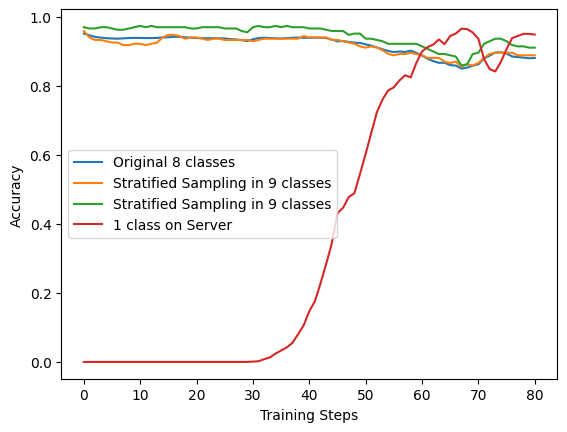

In [35]:
plt.plot(acc_n, label="Original 8 classes")
plt.plot(acc_n_stratified, label="Stratified Sampling in 9 classes")
plt.plot(acc_n_subsampling, label="Stratified Sampling in 9 classes")
plt.plot(acc_m, label="1 class on Server")
plt.xlabel("Training Steps")  
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('comparison_acc_all.png')
plt.show()


In [36]:
""" 
plt.plot(history.history['loss'], label='Training Loss on Server')
plt.xlabel("Training Steps")  
plt.ylabel("Loss")
plt.legend()
plt.savefig('training_loss_server.png')
plt.show()
"""

' \nplt.plot(history.history[\'loss\'], label=\'Training Loss on Server\')\nplt.xlabel("Training Steps")  \nplt.ylabel("Loss")\nplt.legend()\nplt.savefig(\'training_loss_server.png\')\nplt.show()\n'

In [37]:
""" 
plt.plot(history.history['loss'], label='Training Loss on Server')
plt.plot(new_loss, label="Training Loss on Device")
plt.xlabel("Training Steps")  
plt.ylabel("Loss")
plt.legend()
plt.savefig('comparison_loss_all.png')
plt.show()
"""

' \nplt.plot(history.history[\'loss\'], label=\'Training Loss on Server\')\nplt.plot(new_loss, label="Training Loss on Device")\nplt.xlabel("Training Steps")  \nplt.ylabel("Loss")\nplt.legend()\nplt.savefig(\'comparison_loss_all.png\')\nplt.show()\n'

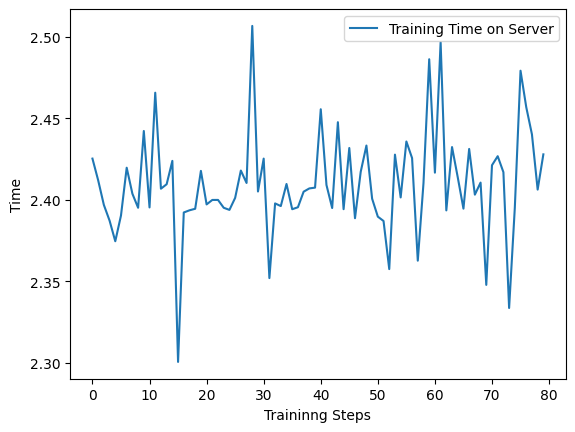

In [38]:
del Time[0]
plt.plot(Time ,label='Training Time on Server')
#plt.plot(device_time ,label='Training Time on Device')
plt.xlabel("Traininng Steps")  
plt.ylabel("Time")
plt.legend()
plt.savefig('Time_all.png')
plt.show()


In [39]:
import numpy as np

mean = np.mean(Time)
median = np.median(Time)
maximum = np.max(Time)
minimum = np.min(Time)
percentile_90 = np.percentile(Time, 90)

print("means=",mean)
print("median=",median)
print("maximum=",maximum)
print("minimum =",minimum )
print("90th Percentiles =", percentile_90)

means= 2.409544897079468
median= 2.4065150022506714
maximum= 2.5066659450531006
minimum = 2.300507068634033
90th Percentiles = 2.4427393198013307


In [40]:
""" 
# Define the output paths
output_paths = {
    'acc_n': '/kaggle/working/server_acc_n.txt',
    'acc_n_stratified': '/kaggle/working/server_acc_n_stratified.txt',
    'acc_n_subsampling': '/kaggle/working/server_acc_n_subsampling.txt',
    'acc_m': '/kaggle/working/server_acc_m.txt',
    'loss_n': '/kaggle/working/server_loss_n.txt',
    'loss_n_stratified': '/kaggle/working/server_loss_n_stratified.txt',
    'loss_n_subsampling': '/kaggle/working/server_loss_n_subsampling.txt',
    'loss_m': '/kaggle/working/server_loss_m.txt',
    'Time': '/kaggle/working/server_time.txt'
}

# Write each list to its corresponding file
with open(output_paths['acc_n'], 'w') as file:
    for item in acc_n:
        file.write(f"{item}\n")

with open(output_paths['acc_n_stratified'], 'w') as file:
    for item in acc_n_stratified:
        file.write(f"{item}\n")

with open(output_paths['acc_n_subsampling'], 'w') as file:
    for item in acc_n_subsampling:
        file.write(f"{item}\n")

with open(output_paths['acc_m'], 'w') as file:
    for item in acc_m:
        file.write(f"{item}\n")

with open(output_paths['loss_n'], 'w') as file:
    for item in loss_n:
        file.write(f"{item}\n")

with open(output_paths['loss_n_stratified'], 'w') as file:
    for item in loss_n_stratified:
        file.write(f"{item}\n")

with open(output_paths['loss_n_subsampling'], 'w') as file:
    for item in loss_n_subsampling:
        file.write(f"{item}\n")

with open(output_paths['loss_m'], 'w') as file:
    for item in loss_m:
        file.write(f"{item}\n")

with open(output_paths['Time'], 'w') as file:
    for item in Time:
        file.write(f"{item}\n")
""" 

' \n# Define the output paths\noutput_paths = {\n    \'acc_n\': \'/kaggle/working/server_acc_n.txt\',\n    \'acc_n_stratified\': \'/kaggle/working/server_acc_n_stratified.txt\',\n    \'acc_n_subsampling\': \'/kaggle/working/server_acc_n_subsampling.txt\',\n    \'acc_m\': \'/kaggle/working/server_acc_m.txt\',\n    \'loss_n\': \'/kaggle/working/server_loss_n.txt\',\n    \'loss_n_stratified\': \'/kaggle/working/server_loss_n_stratified.txt\',\n    \'loss_n_subsampling\': \'/kaggle/working/server_loss_n_subsampling.txt\',\n    \'loss_m\': \'/kaggle/working/server_loss_m.txt\',\n    \'Time\': \'/kaggle/working/server_time.txt\'\n}\n\n# Write each list to its corresponding file\nwith open(output_paths[\'acc_n\'], \'w\') as file:\n    for item in acc_n:\n        file.write(f"{item}\n")\n\nwith open(output_paths[\'acc_n_stratified\'], \'w\') as file:\n    for item in acc_n_stratified:\n        file.write(f"{item}\n")\n\nwith open(output_paths[\'acc_n_subsampling\'], \'w\') as file:\n    for it